# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [ ]:
%tensorflow_version 2.x

In [ ]:
!wget https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
!unzip resources.zip

--2021-02-04 02:14:03--  https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tuvrbsby4a5axe0/resources.zip [following]
--2021-02-04 02:14:03--  https://www.dropbox.com/s/raw/tuvrbsby4a5axe0/resources.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ac8134718052760ec6810fdfc.dl.dropboxusercontent.com/cd/0/inline/BISwY7dAFrz7PX42nDi_cjdGsJuhtr67FtJJ-7gzXywFp67Sa124ntPAN7C7keYgOrtZ0-YOo4zp4iM1VZC9nzPy4--Cr4AD9Sune59oALlWXw/file# [following]
--2021-02-04 02:14:03--  https://uc3ac8134718052760ec6810fdfc.dl.dropboxusercontent.com/cd/0/inline/BISwY7dAFrz7PX42nDi_cjdGsJuhtr67FtJJ-7gzXywFp67Sa124ntPAN7C7keYgOrtZ0-YOo4zp4iM1VZC9nzPy4--Cr4AD9Sune59oALlWXw/file
Resolving uc3

In [ ]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 9.3MB/s 


In [ ]:
%tensorflow_version 2.x

In [ ]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [ ]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [ ]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [ ]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [ ]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [ ]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [ ]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 277 ms, sys: 1.15 ms, total: 278 ms
Wall time: 283 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:])
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [ ]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [ ]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [ ]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set)) 
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)
    return df

## 4. Train a model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [ ]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=10,verbose=1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 102, 32)           480608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 102, 64)           12672     
_________________________________________________________________
dropout_2 (Dropout)          (None, 102, 64)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 13s 23ms/step - loss: 0.3913 - categorical_accuracy: 0.3572
Epoch

In [ ]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 7s 23ms/step - loss: 0.0178 - categorical_accuracy: 0.9625
Epoch 2/10
290/290 [==============================] - 6s 22ms/step - loss: 0.0171 - categorical_accuracy: 0.9636
Epoch 3/10
290/290 [==============================] - 6s 22ms/step - loss: 0.0165 - categorical_accuracy: 0.9648
Epoch 4/10
290/290 [==============================] - 6s 22ms/step - loss: 0.0158 - categorical_accuracy: 0.9660
Epoch 5/10
290/290 [==============================] - 7s 23ms/step - loss: 0.0153 - categorical_accuracy: 0.9671
Epoch 6/10
290/290 [==============================] - 6s 21ms/step - loss: 0.0148 - categorical_accuracy: 0.9680
Epoch 7/10
290/290 [==============================] - 7s 22ms/step - loss: 0.0143 - categorical_accuracy: 0.9689
Epoch 8/10
290/290 [==============================] - 6s 22ms/step - loss: 0.0139 - categorical_accuracy: 0.9700
Epoch 9/10
290/290 [==============================] - 6s 22ms/step - loss: 0.0135 - categorical_

In [ ]:
%%time
#model.save_weights('/data/my_pos_no_crf.h5')
#model.load_weights('/data/my_pos_no_crf.h5')
y_pred = model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
report = evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.756,99.8372,99.7966,3679
1,2,94.8671,93.4408,94.1485,7707
2,3,90.8686,95.3935,93.0761,16111
3,4,99.8991,99.6518,99.7753,12877
4,5,95.6522,98.5075,97.0588,66
5,6,98.1443,91.1877,94.5382,476
6,7,98.0507,96.7773,97.4098,2012
7,8,75.502,45.3012,56.6265,188
8,9,63.1868,62.5,62.8415,230
9,10,62.0387,42.0739,50.142,353


CPU times: user 3.26 s, sys: 109 ms, total: 3.37 s
Wall time: 3.05 s


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py



### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [ ]:
from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
input = Input(shape=(102,), dtype='int32')
output = Embedding(input_dim=len(word_to_idx), output_dim=32,input_length=102,mask_zero=True)(input)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation=None))(output)
crf = CRF(dtype='float32')
output =crf(output)

model_crf = Model(input, output)
model_crf = ModelWithCRFLoss(model_crf)
model_crf.compile(optimizer=Adam(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

callback_crf = [TensorBoard(log_dir='./Graph/crf', histogram_freq=1, write_graph=True, write_grads=False)]

In [ ]:
# change it to list of int insteadd of one hot
# model_crf.fit(x=x_train,y=y_train.argmax(axis=2), batch_size=64, epochs=20, verbose=1, validation_split=0.3, callbacks=callback_crf)

Epoch 1/20
203/203 [==============================] - 71s 310ms/step - crf_loss: 32.8417 - accuracy: 0.4467 - val_crf_loss_val: 13.0591 - val_val_accuracy: 0.8003
Epoch 2/20
203/203 [==============================] - 59s 290ms/step - crf_loss: 8.4812 - accuracy: 0.8769 - val_crf_loss_val: 5.8174 - val_val_accuracy: 0.8949
Epoch 3/20
203/203 [==============================] - 59s 290ms/step - crf_loss: 4.6046 - accuracy: 0.9246 - val_crf_loss_val: 4.5227 - val_val_accuracy: 0.9114
Epoch 4/20
203/203 [==============================] - 59s 289ms/step - crf_loss: 3.4094 - accuracy: 0.9408 - val_crf_loss_val: 3.8996 - val_val_accuracy: 0.9176
Epoch 5/20
203/203 [==============================] - 59s 290ms/step - crf_loss: 2.8643 - accuracy: 0.9469 - val_crf_loss_val: 3.5299 - val_val_accuracy: 0.9210
Epoch 6/20
203/203 [==============================] - 60s 293ms/step - crf_loss: 2.5345 - accuracy: 0.9521 - val_crf_loss_val: 3.3194 - val_val_accuracy: 0.9230
Epoch 7/20
203/203 [============

In [ ]:
model_crf.build((102,None))
model_crf.load_weights("crf.h5")

In [ ]:
%%time
y_pred2 = model_crf.predict(x_test)
ypred2 = [outputToLabel(y_pred2[1][i],len(y_test[i])) for i in range(len(y_pred2[1]))]
report2 = evaluation_report(y_test, ypred2)

,tag,precision,recall,f_score,correct_count
0,1,99.81,99.7829,99.7964,3677
1,2,93.5277,93.7318,93.6296,7731
2,3,90.3055,95.1981,92.6873,16078
3,4,99.8991,99.6208,99.7598,12873
4,5,81.25,97.0149,88.4354,65
5,6,98.2833,87.7395,92.7126,458
6,7,97.6317,97.1621,97.3963,2020
7,8,56.7976,45.3012,50.4021,188
8,9,69.8925,52.9891,60.2782,195
9,10,60.4736,39.5709,47.8386,332


CPU times: user 20.7 s, sys: 2.79 s, total: 23.5 s
Wall time: 19.4 s


In [ ]:
model_crf.save_weights("crf.h5")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./Graph/crf'


### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [ ]:
from embeddings.emb_reader import get_embeddings
from tensorflow.keras.initializers import Constant

In [ ]:
embeddings_index = get_embeddings()
num_tokens = len(word_to_idx)
embedding_dim = 64
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3706 words (11313 misses)


In [ ]:
input = Input(shape=(102,), dtype='int32')
output = Embedding(input_dim=len(word_to_idx), output_dim=64,input_length=102,mask_zero=True, embeddings_initializer=Constant(embedding_matrix), trainable=True)(input)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation=None))(output)
crf_emb = CRF(dtype='float32')
output = crf_emb(output)

model_crf_emb = Model(input, output)
model_crf_emb = ModelWithCRFLoss(model_crf_emb)
model_crf_emb.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

callback_crf_emb = [TensorBoard(log_dir='./Graph/crf_emb', histogram_freq=1, write_graph=True, write_grads=False)]

In [ ]:
# change it to list of int insteadd of one hot
model_crf_emb.fit(x_train, y_train.argmax(axis=2), batch_size=64, epochs=20, verbose=1, validation_split=0.3, callbacks=callback_crf_emb)

Epoch 1/20
203/203 [==============================] - 71s 313ms/step - crf_loss: 27.8068 - accuracy: 0.5361 - val_crf_loss_val: 9.1507 - val_val_accuracy: 0.8302
Epoch 2/20
203/203 [==============================] - 59s 292ms/step - crf_loss: 6.7552 - accuracy: 0.8954 - val_crf_loss_val: 4.6284 - val_val_accuracy: 0.9052
Epoch 3/20
203/203 [==============================] - 59s 293ms/step - crf_loss: 3.7928 - accuracy: 0.9359 - val_crf_loss_val: 3.7067 - val_val_accuracy: 0.9185
Epoch 4/20
203/203 [==============================] - 60s 294ms/step - crf_loss: 2.9135 - accuracy: 0.9470 - val_crf_loss_val: 3.2713 - val_val_accuracy: 0.9231
Epoch 5/20
203/203 [==============================] - 60s 294ms/step - crf_loss: 2.5130 - accuracy: 0.9526 - val_crf_loss_val: 3.1146 - val_val_accuracy: 0.9248
Epoch 6/20
203/203 [==============================] - 59s 293ms/step - crf_loss: 2.2884 - accuracy: 0.9560 - val_crf_loss_val: 2.9352 - val_val_accuracy: 0.9264
Epoch 7/20
203/203 [=============

In [ ]:
model_crf_emb.build((102, None))
model_crf_emb.load_weights("crf_emb.h5")

In [ ]:
%%time
y_pred3 = model_crf_emb.predict(x_test)
ypred3 = [outputToLabel(y_pred3[1][i],len(y_test[i])) for i in range(len(y_pred3[1]))]
report3 = evaluation_report(y_test, ypred3)

,tag,precision,recall,f_score,correct_count
0,1,99.891,99.4844,99.6873,3666
1,2,93.1919,94.2653,93.7255,7775
2,3,90.3651,95.8494,93.0265,16188
3,4,99.9612,99.6131,99.7868,12872
4,5,88,98.5075,92.9577,66
5,6,97.2632,88.5057,92.678,462
6,7,97.2102,97.2102,97.2102,2021
7,8,62.6062,53.253,57.5521,221
8,9,77.1218,56.7935,65.4147,209
9,10,60.9665,39.0942,47.6398,328


CPU times: user 20.3 s, sys: 2.12 s, total: 22.4 s
Wall time: 13.7 s


In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./Graph/crf_emb'

In [ ]:
model_crf_emb.save_weights("crf_emb.h5")

## #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
tag_set = set()
for a,b in label_to_idx.items() :
    tag_set.add((b,a))
tagDF = pd.DataFrame(sorted(tag_set), columns=["tag", "tag_name"])
tagDF = pd.concat([pd.DataFrame([{"tag":0, "tag_name":""}]), tagDF], ignore_index=True)
tagDF

In [ ]:
_report = report.drop(len(report)-1).replace("-", 0)
_report2 = report2.drop(len(report)-1).replace("-", 0)
_report3 = report3.drop(len(report)-1).replace("-",0)

In [161]:
_report_n = _report.merge(tagDF, how="right", on="tag").dropna()
_report_n2 = _report2.merge(tagDF, how="right", on="tag").dropna()
_report_n3 = _report3.merge(tagDF, how="right", on="tag").dropna()

### 4.1, 4.2.1, 4.2.2's  f_score comparison
From the line chart that compare f_score of 4.1, 4.2.1 and 4.2.2 below we could se that f_score of 4.1 are slightly better than the others follow by 4.2.2 then 4.2.1 which mean overall POS tagger without CRF is the best follow by CRF with pretrained embedding then with out it.


In [177]:
acc = report.tag[len(report)-1][-5:]
acc2 = report2.tag[len(report)-1][-5:]
acc3 = report3.tag[len(report)-1][-5:]
print(acc, acc2, acc3)

92.93 92.31 92.50


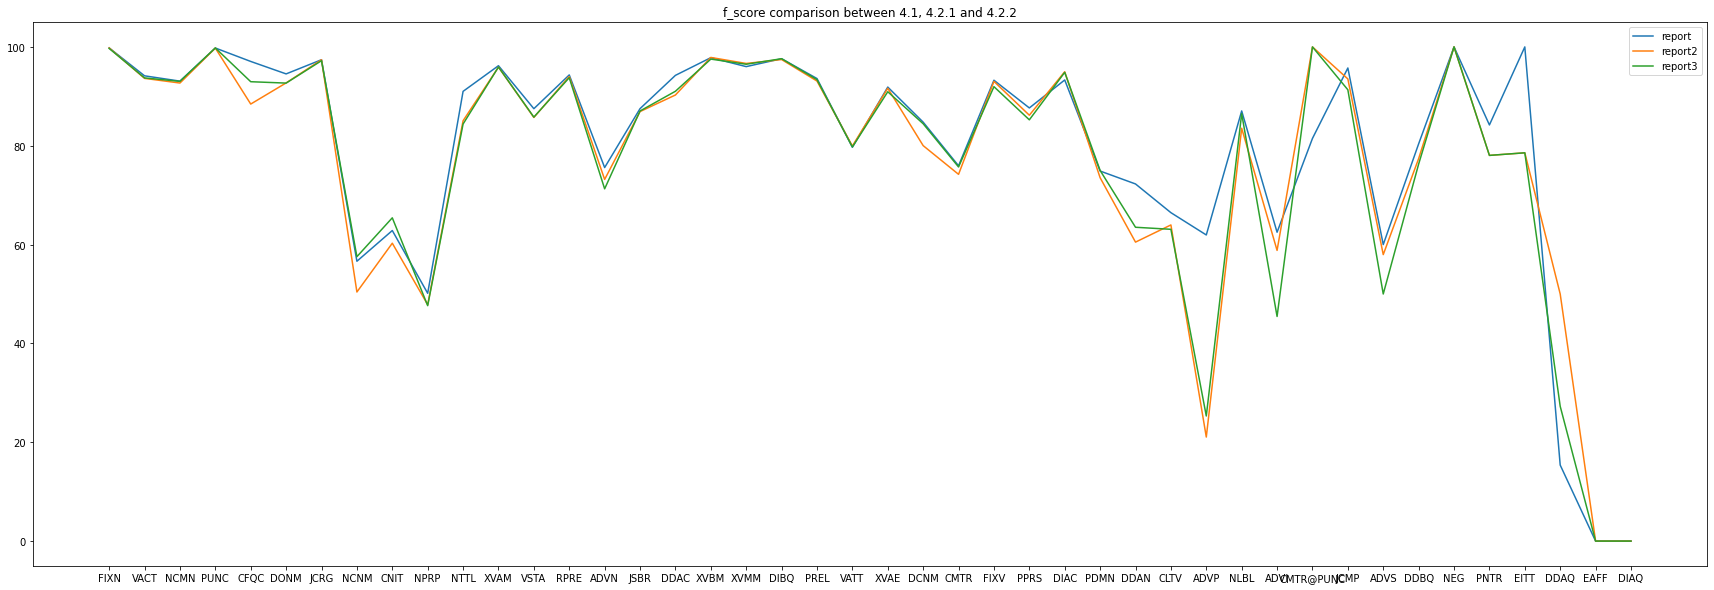

In [162]:
plt.figure(figsize=(30,10))
plt.plot(_report_n.tag_name, _report_n.f_score, label="report")
plt.plot(_report_n2.tag_name, _report_n2.f_score, label="report2")
plt.plot(_report_n3.tag_name, _report_n3.f_score, label="report3")
plt.legend()
plt.title("f_score comparison between 4.1, 4.2.1 and 4.2.2")
plt.show()

### Different of 4.1 to 4.2.1 and 4.1 to 4.2.2
both line chart show that most of the time POS tagger without CRF is better than with CRF with or without pretrained-embedding but on some tag the tagger without CRF is worse such as CMTR@PUNC or DDAQ tag and some is much better


In [132]:
def subtractAndTagName(report1, report2, tagDF):
    sub = pd.DataFrame(report1.f_score.subtract(report2.f_score))
    merged = sub.merge(tagDF, how="right", left_on=_report_n.index, right_on="tag") 
    return merged.dropna()

In [136]:
report12 = subtractAndTagName(_report_n, _report_n2, tagDF)
report13 = subtractAndTagName(_report_n, _report_n3, tagDF)
report23 = subtractAndTagName(_report_n2, _report_n3, tagDF)

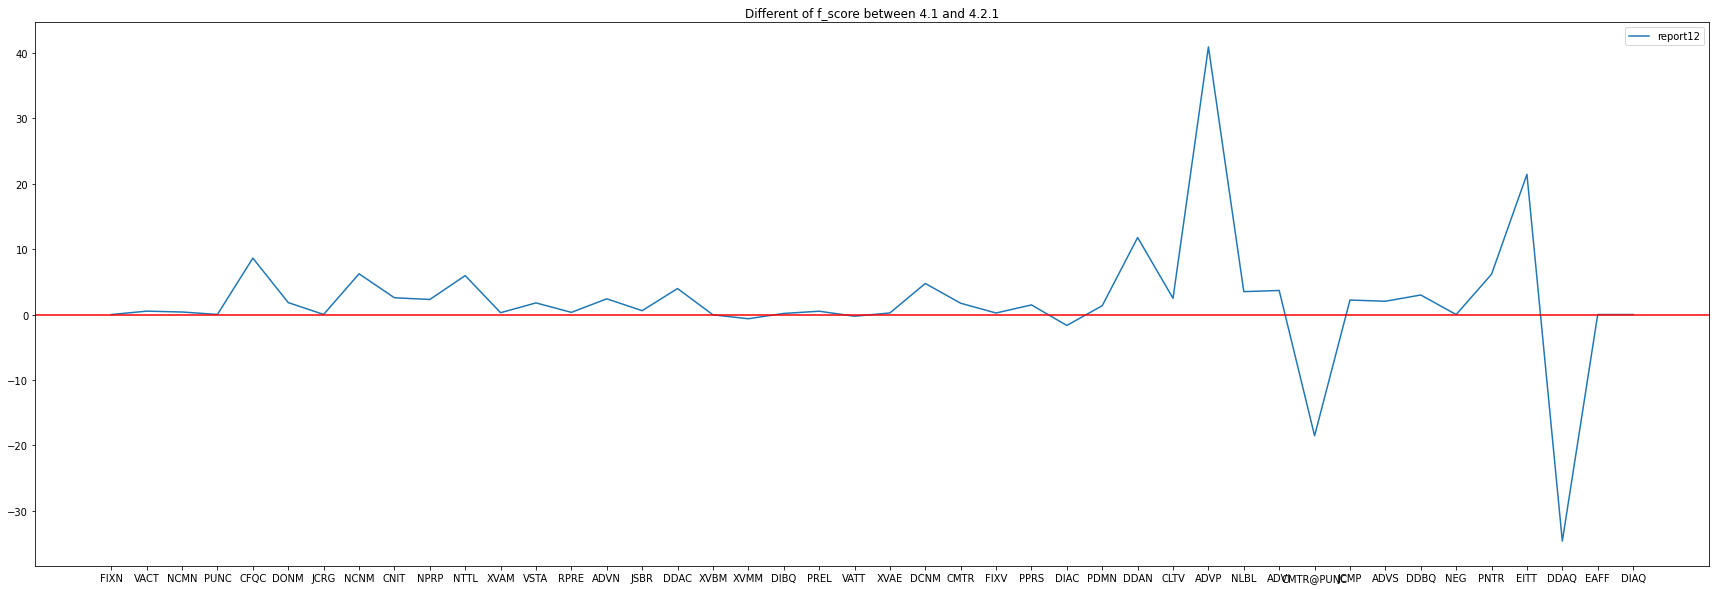

In [145]:
plt.figure(figsize=(30,10))
plt.plot(report12.tag_name, report12.f_score, label="report12")
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.title("Different of f_score between 4.1 and 4.2.1")
plt.show()

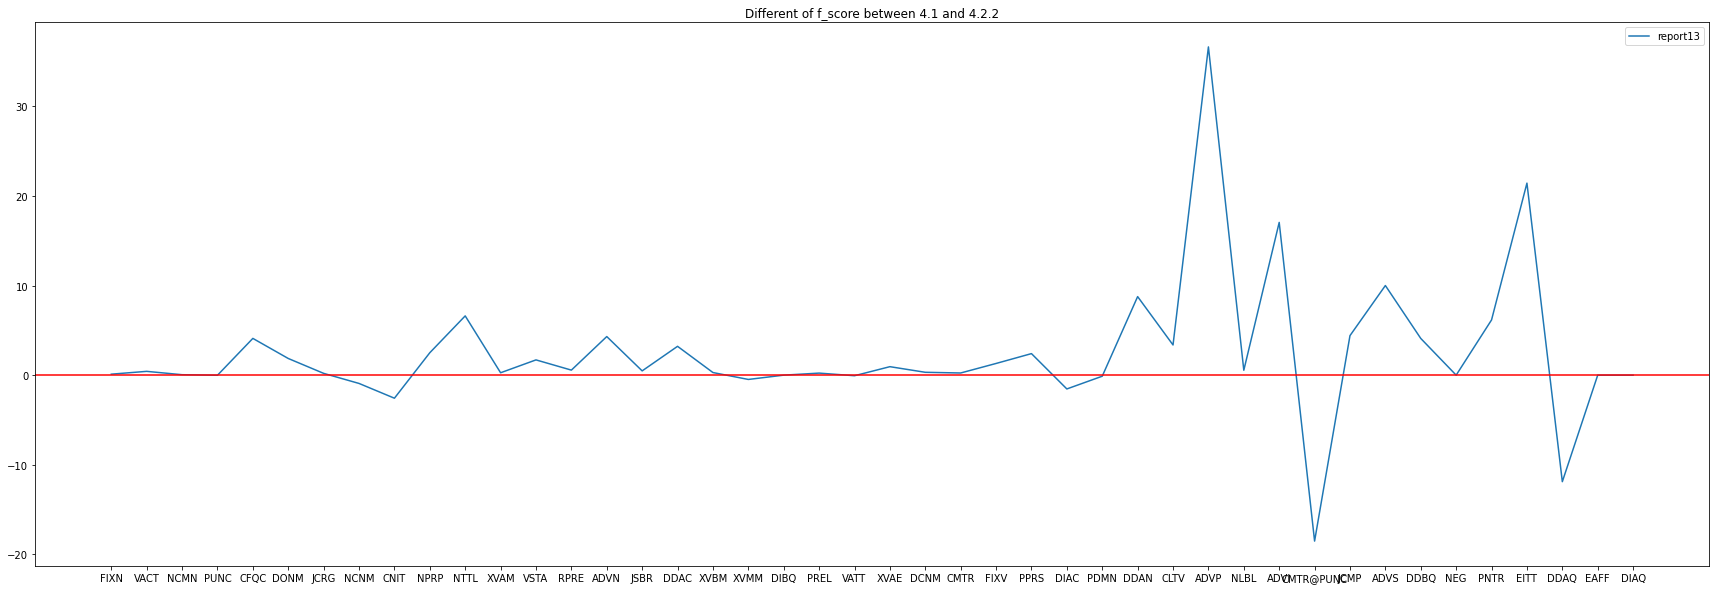

In [151]:
plt.figure(figsize=(30,10))
plt.plot(report13.tag_name, report13.f_score, label="report13")
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.title("Different of f_score between 4.1 and 4.2.2")
plt.show()

Line chart below show that CRf with and without pre-trained embedding are not significantly different, but CRF without is highly confident in some tags such as ADYM, ADVS and DDAQ which shown that the pre-trained embedding may have wider vocab that may affect these tags's accuracy.

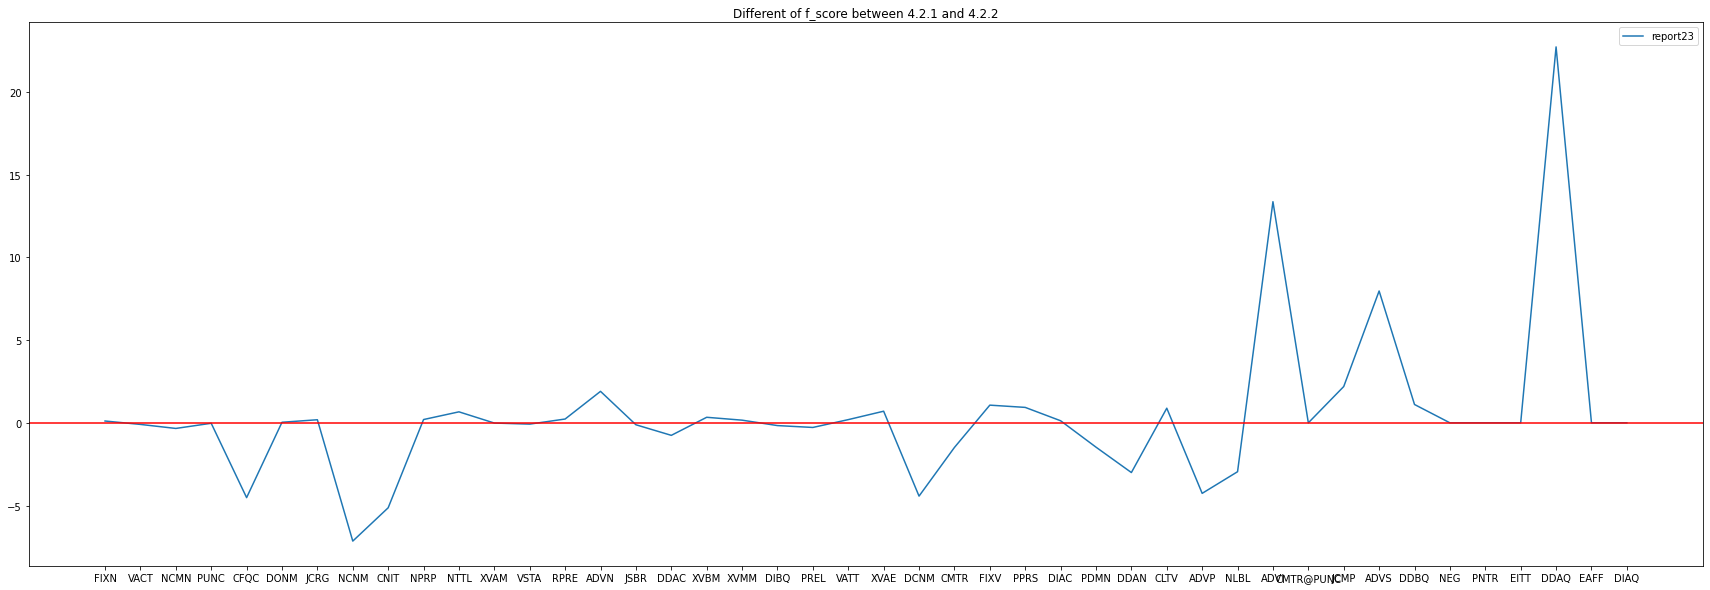

In [179]:
plt.figure(figsize=(30,10))
plt.plot(report23.tag_name, report23.f_score, label="report23")
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
plt.title("Different of f_score between 4.2.1 and 4.2.2")
plt.show()

### Summarize
Overall: Without CRF > with CRF+pre-trained embedding > CRF

## #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here :</b> Since the distribution of the value in transition matrix to existent of tag_from, tag_to don't have significantly diferent, so the matrix is insensible. But the distribution graph do show that most of False exist around 0.

In [326]:
def get_position(matrix):
    myList = []
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            myList.append([matrix[i][j], i, j])
    return pd.DataFrame(myList, columns=["value", "from", "to"])

In [327]:
def sortAndTagTransition(matrix, tagDF):
    data = get_position(matrix)
    data_merge_from = data.merge(tagDF, how="right", left_on="from", right_on="tag")
    data_merge_to = data_merge_from.merge(tagDF, how="right", left_on="to", right_on="tag")
    data_sort = data_merge_to.sort_values(by="value", ascending=False)
    clean = data_sort.drop(columns=["from", "to", "tag_x", "tag_y"], axis=1)
    rename = clean.rename({"tag_name_x":"tag_from", "tag_name_y":"tag_to"}, axis=1)
    out = rename.reset_index(drop=True)
    return out

In [333]:
def getFollower(datalist) :
    tag_follower = dict()
    for data in datalist:
        for i in range(len(data)):
            for j in range(len(data[i])-1):
                a = data[i][j][1]
                b = data[i][j+1][1]
                if a in tag_follower : tag_follower[a][b] = (data[i][j][0], data[i][j+1][0])
                else : tag_follower[a] = {b:(data[i][j][0], data[i][j+1][0])}
    return tag_follower

In [334]:
def checkExist(row, follower_dict):
    return row.tag_from in follower_dict and row.tag_to in follower_dict[row.tag_from]

In [357]:
def addWordAtTrue(row, follower_dict):
    if row.check :
        return follower_dict[row.tag_from][row.tag_to]
    else :
        return None

In [403]:
def print_information(matrix, tagDF, follower_dict):
    sorted_val = sortAndTagTransition(matrix, tagDF)
    sorted_val = sorted_val.replace("", np.NaN).dropna(axis=0)
    sorted_val["check"] = sorted_val.apply(lambda row: checkExist(row, follower_dict), axis=1)
    sorted_val["Sequence"] = sorted_val.apply(lambda row: addWordAtTrue(row, follower_dict), axis=1)

    print("All True count = {}".format(sorted_val.check.sum()))
    print("All count = {}".format(len(sorted_val)))
    print("Positive True count = {}".format(sorted_val[sorted_val.value > 0].check.sum()))
    print("Positive count = {}".format(len(sorted_val[sorted_val.value > 0])))
    print("Negative True count = {}".format(sorted_val[sorted_val.value < 0].check.sum()))
    print("Negative count = {}".format(len(sorted_val[sorted_val.value < 0])))
    
    print("\n---------------Top 20 data---------------")
    display(sorted_val.head(20))
    print("\n----------First false occurance----------")
    display(sorted_val[sorted_val.check==False].head(1))
    return sorted_val

In [348]:
crf_transitions = crf.transitions.numpy()
crf_emb_transitions = crf_emb.transitions.numpy()

In [349]:
follower_dict = getFollower([train_data, test_data])

In [401]:
crf_transition_p = print_information(crf_transitions, tagDF, follower_dict)

All True count = 1024
All count = 2209
Positive True count = 376
Positive count = 573
Negative True count = 648
Negative count = 1636

---------------Top 20 data---------------


,value,tag_from,tag_to,check,Sequence
0,1.030347,DIBQ,CNIT,True,"(หลาย, ชิ้น)"
1,1.029874,FIXN,FIXV,True,"(เป็น, อย่าง)"
2,1.002321,FIXV,VSTA,True,"(อย่าง, เหมาะสม)"
3,0.984472,FIXV,VATT,True,"(โดย, ง่าย)"
4,0.883278,DCNM,CMTR,True,"(3, mw.)"
5,0.825680,JCMP,NCMN,True,"(กว่า, ต่างประเทศ)"
6,0.823390,CNIT,DCNM,True,"(ประการ, หนึ่ง)"
7,0.759282,NCMN,DDAN,True,"(รถไฟฟ้า, ทั้งหมด)"
8,0.739413,VATT,JCMP,True,"(ถูก, กว่า)"
9,0.735557,DCNM,CMTR@PUNC,True,"(50, %)"



----------First false occurance----------


,value,tag_from,tag_to,check,Sequence
113,0.288987,DIBQ,CVBL,False,None


check
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: value, dtype: object

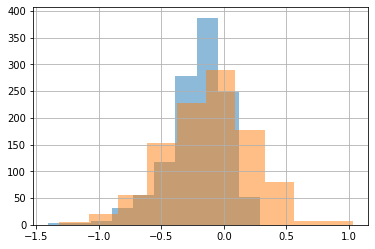

In [410]:
crf_transition_p.groupby("check").value.hist(alpha=0.5)

In [402]:
crf_emb_transition_p = print_information(crf_emb_transitions, tagDF, follower_dict)

All True count = 1024
All count = 2209
Positive True count = 389
Positive count = 591
Negative True count = 635
Negative count = 1618

---------------Top 20 data---------------


,value,tag_from,tag_to,check,Sequence
0,0.814974,CNIT,DDAC,True,"(แบบ, นี้)"
1,0.809099,FIXV,VATT,True,"(โดย, ง่าย)"
2,0.758991,FIXN,FIXV,True,"(เป็น, อย่าง)"
3,0.707808,VATT,JCMP,True,"(ถูก, กว่า)"
4,0.654060,NTTL,NPRP,True,"(Dr., Mongkol)"
5,0.652345,FIXV,VSTA,True,"(อย่าง, เหมาะสม)"
6,0.641507,DIBQ,CNIT,True,"(หลาย, ชิ้น)"
7,0.622012,VSTA,XVAE,True,"(แตกต่าง, ไป)"
8,0.620279,NEG,VATT,True,"(ไม่, มาก)"
9,0.606275,NEG,XVAM,True,"(ไม่, สามารถ)"



----------First false occurance----------


,value,tag_from,tag_to,check,Sequence
60,0.352521,DDAN,NTTL,False,None


check
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: value, dtype: object

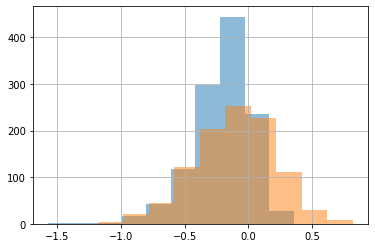

In [416]:
crf_emb_transition_p.groupby("check").value.hist(alpha=0.5)